# Inspection

Here we can investigate the properties of each model that is made.

In [1]:
import ipywidgets as widgets
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from IPython.display import clear_output
from kosmatau3d import models
from pprint import pprint

In [2]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/'

Model

In [3]:
model = 'r400_fhi1.0_fuv1.0'

## Profiles

Here we simply want to examine to examine the various profiles we use to model the Milky Way.

In [4]:
data_dir = models.constants.INPUTPATH + 'MilkyWay/'

### H$_2$ and HI mass

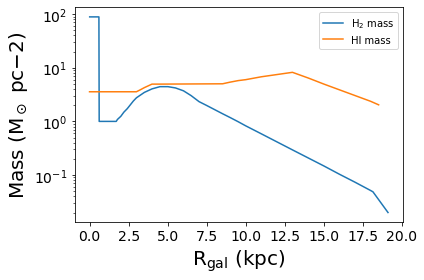

In [15]:
%matplotlib inline
h2_mass = pd.read_csv(data_dir + 'h2_mass_profile.dat', delim_whitespace=True, names=['r1', r'H$_2$ mass'], skiprows=1)
hi_mass = pd.read_csv(data_dir + 'hi_mass_profile.dat', delim_whitespace=True, names=['r2', 'HI mass'], skiprows=1)
# mass = pd.concat((h2_mass, hi_mass), axis=1)
fig, ax = plt.subplots(1, 1)
h2_mass.plot(x='r1', y=r'H$_2$ mass', logy=True, ax=ax, fontsize=14)
hi_mass.plot(x='r2', y='HI mass', logy=True, ax=ax, fontsize=14)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=20)
ax.set_ylabel(r'Mass (M$_\odot$ pc${-2}$)', fontsize=20)
fig.tight_layout()
plt.savefig('plots/mass_dist.png') ;

In [24]:
h2_mass[r'H$_2$ mass'].max()

88.820835

### HI mass

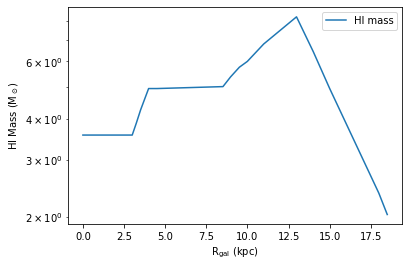

In [69]:
%matplotlib inline
hi_mass = pd.read_csv(data_dir + 'hi_mass_profile.dat', delim_whitespace=True, names=['r', 'HI mass'], skiprows=1)
hi_mass.plot(x='r', y='HI mass', logy=True, xlabel=r'R$_\mathrm{gal}$ (kpc)', ylabel=r'HI Mass (M$_\odot$)');

### Number density

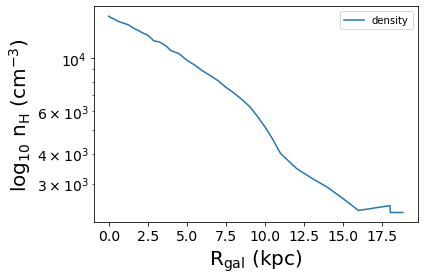

In [16]:
%matplotlib inline
density = pd.read_csv(data_dir + 'densities_clouds.dat', delim_whitespace=True, names=['r', 'density'], skiprows=1)
fig, ax = plt.subplots(1, 1)
density.plot(x='r', y='density', ax=ax, logy=True, fontsize=14)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=20)
ax.set_ylabel(r'log$_{10}$ n$_\mathrm{H}$ (cm$^{-3}$)', fontsize=20)
fig.tight_layout()
plt.savefig('plots/density_dist.png');

### far-UV

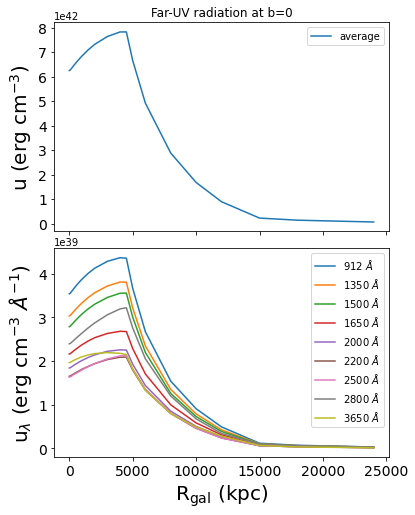

In [23]:
%matplotlib inline
fuv = pd.read_csv(data_dir + 'galactic_FUV_complete.dat', delim_whitespace=True, names=['r', 'z', 'average', r'912 $\AA$', r'1350 $\AA$', r'1500 $\AA$', r'1650 $\AA$', r'2000 $\AA$', r'2200 $\AA$', r'2500 $\AA$', r'2800 $\AA$', r'3650 $\AA$'], skiprows=1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace':0.08}, figsize=(6, 8))
fuv.groupby('r').max().reset_index().plot(x='r', y='average', ax=ax1, title='Far-UV radiation at b=0', fontsize=14)
fuv.groupby('r').max().reset_index().plot(x='r', y=[r'912 $\AA$', r'1350 $\AA$', r'1500 $\AA$', r'1650 $\AA$', r'2000 $\AA$', r'2200 $\AA$', r'2500 $\AA$', r'2800 $\AA$', r'3650 $\AA$'], ax=ax2, fontsize=14)
ax2.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=20)
ax1.set_ylabel(r'u (erg cm$^{-3}$)', fontsize=20)
ax2.set_ylabel(r'u$_\lambda$ (erg cm$^{-3}$ $\AA^{-1}$)', fontsize=20)
# fig.tight_layout()
plt.savefig('plots/fuv_dist.png');

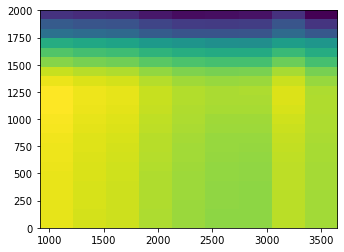

In [121]:
plt.imshow(np.log10(fuv.groupby('r').max()[[912, 1350, 1500, 1650, 2000, 2200, 2500, 2800, 3650]]).to_numpy()[::-1, :], extent=(912, 3650, 0, 2000))

## Distributions

### Mass

In [4]:
positions = fits.open(base_dir + model + '/voxel_position.fits')
mass = fits.open(base_dir + model + '/voxel_ensemble_mass.fits')

In [7]:
mass[0].data.sum(1).shape, x.shape

((6349,), (6349,))

In [15]:
z.max()

1.0

In [20]:
x, y, z = positions[0].data.T
z = np.random.rand(z.size)
values = mass[0].data.sum(1)*400
fig = go.Figure(data=go.Volume(x=x, 
                               y=y, 
                               z=z, 
                               value=values, 
                               isomin=0, 
                               isomax=values.max(), 
                               opacity=0.5, 
                               surface_count=50))

In [ ]:
fig.show()

### Intensity

In [31]:
intensity = fits.open(base_dir + model + '/synthetic_intensity.fits')
# pprint(intensity[1].header)

In [26]:
lon = np.linspace(intensity[1].header['CRVAL2'] - (intensity[1].header['CRPIX2']-0.5)*intensity[1].header['CDELT2'],
                  intensity[1].header['CRVAL2'] + (intensity[1].header['CRPIX2']-0.5)*intensity[1].header['CDELT2'],
                  num=intensity[1].header['NAXIS2'])
lat = np.linspace(intensity[1].header['CRVAL3'] - (intensity[1].header['CRPIX3']-0.5)*intensity[1].header['CDELT3'],
                  intensity[1].header['CRVAL3'] + (intensity[1].header['CRPIX3']-0.5)*intensity[1].header['CDELT3'],
                  num=intensity[1].header['NAXIS3'])
vel = np.linspace(intensity[1].header['CRVAL4'] - (intensity[1].header['CRPIX4']-0)*intensity[1].header['CDELT4'],
                  intensity[1].header['CRVAL4'] + (intensity[1].header['CRPIX4']-0)*intensity[1].header['CDELT4'],
                  num=intensity[1].header['NAXIS4'])

In [27]:
x, y, z = np.meshgrid(vel, lat, lon)
values = intensity[1].data[:, :, :, 0]

fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

In [28]:
fig.show()

## Observational data

In [31]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/COGAL/'

# obs = fits.open(base_dir + 'COGAL_deep_interp.fits')
obs = fits.open(base_dir + 'regridded/temp/co1_test_regridded.fits')
x = np.arange(obs[0].header['NAXIS1'])
y = np.arange(obs[0].header['NAXIS2'])
z = np.arange(obs[0].header['NAXIS3'])
X, Y, Z = np.meshgrid(x, y, z)
fig = go.Figure(data=go.Volume(x=X.flatten(), y=Y.flatten(), z=Z.flatten(), value=obs[0].data.flatten(), surface_count=20))

In [32]:
fig.show()

In [8]:
np.where(np.isnan(obs[0].data))[0].size

42008126

## Examples

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np


def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((17, 17, 17)) / 16.0
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)

# define a sphere about [0.5, 0.5, 0.5]
sphere = (rc - 0.5)**2 + (gc - 0.5)**2 + (bc - 0.5)**2 < 0.5**2

# combine the color components
colors = np.zeros(sphere.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc

# and plot everything
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(r, g, b, sphere,
          facecolors=colors,
          # edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          alpha=0.7,
          linewidth=0.5)
ax.set(xlabel='r', ylabel='g', zlabel='b') ;

In [17]:
np.where(np.isnan(values))[0].size

0

In [20]:
values.shape

(40, 40, 40)

In [ ]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=-0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
x, y, z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(x*y*z) / (x*y*z)
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()